In [ ]:
# !pip install -q finpy-tse

# import finpy_tse as fpy

# df = fpy.Get_CWI_History(
#     start_date='1390-01-01',
#     end_date='1402-03-15',
#     ignore_date=False,
#     just_adj_close=False,
#     show_weekday=False,
#     double_date=False)

# df.to_csv('tse.csv', sep=',')

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, LeakyReLU, Flatten, Lambda
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import sklearn.metrics as sklearn_metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.svm import SVR

np.random.seed(0)

# Data Loading

In [ ]:
def add_Ma(dataFrame):
    Ma_window = 5
    for i in range(0, dataFrame.shape[0] - Ma_window):
        dataFrame.loc[dataFrame.index[i + Ma_window], 'Ma'] = np.round(
            ((dataFrame.iloc[i, 4] +
              dataFrame.iloc[i + 1, 4] +
              dataFrame.iloc[i + 2, 4] +
              dataFrame.iloc[i + 3, 4] +
              dataFrame.iloc[i + 4, 4]) / 5), 6)   
    return dataFrame[5:-5]

DataFrame = pd.read_csv('tse.csv')
DataFrame = DataFrame.drop(columns=['J-Date'])
DataFrame = DataFrame.drop(columns=['Volume'])  # It is not removed in the main project code, but if it is removed, the accuracy will be better
DataFrame = add_Ma(DataFrame)


In [ ]:
DataFrame.head()

,Open,High,Low,Close,Adj Close,Ma
5,24498.0,24590.0,24498.0,24544.0,24543.6,24243.30
6,24553.0,25023.0,24553.0,25023.0,25023.3,24400.76
7,25035.0,25550.0,25035.0,25550.0,25550.4,24565.46
8,25556.0,25885.0,25556.0,25885.0,25885.1,24817.98
9,25908.0,26272.0,25908.0,26223.0,26222.7,25097.68


In [ ]:
DataFrame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,2924.0,443126.505472,610480.786063,0.00,64038.250,80980.50,934342.500,2548220.00
High,2924.0,446325.700752,614402.730865,23852.00,64349.250,81258.00,966604.750,2548220.00
Low,2924.0,441675.939808,607408.390579,23768.00,64040.000,80929.00,934342.500,2527540.00
Close,2924.0,444093.043092,611008.347591,23787.00,64189.750,81124.00,957110.000,2535236.00
Adj Close,2924.0,444092.774282,611008.167142,23787.30,64190.000,81124.40,957110.025,2535236.50
Ma,2924.0,441732.534945,608033.244886,23924.96,64064.255,80974.32,922083.915,2505644.26


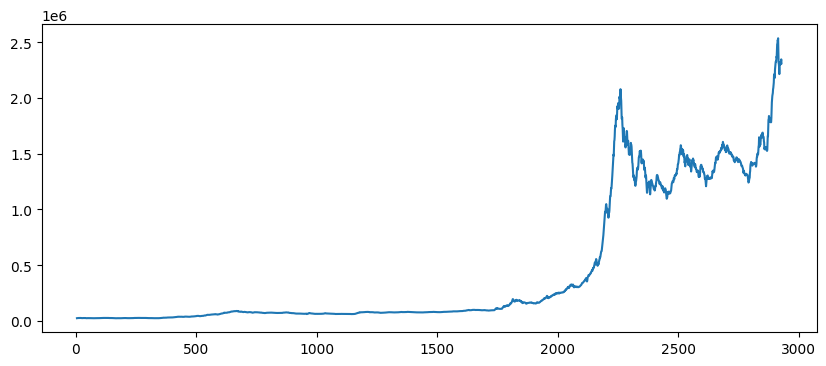

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(DataFrame['Close'])
plt.show()

# Preprocessing

In [ ]:
class Standarized_TimeseriesGenerator(TimeseriesGenerator):
    def __getitem__(self, index):
        samples, goals = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
        avg = samples.mean(axis=1)
        st = samples.std(axis=1)
        samples = (samples - avg[:, None, :]) / st[:, None, :]
        goals = (goals - avg) / st
        return samples, goals

def get_data_gen(dataset):
    data_gen_trainning = Standarized_TimeseriesGenerator(
        dataset, dataset, length=n_sequence, sampling_rate=1, stride=1, batch_size=n_batch,
        start_index=0, end_index=train_size, shuffle=True)    
    data_gen_testing = Standarized_TimeseriesGenerator(
        dataset, dataset, length=n_sequence, sampling_rate=1, stride=1, batch_size=n_batch,
        start_index=train_size, end_index=dataset.shape[0] - 1)    
    return data_gen_trainning, data_gen_testing

def get_data_gen_raw(dataset):
    data_gen_trainning = TimeseriesGenerator(
        dataset, dataset, length=n_sequence, sampling_rate=1, stride=1, batch_size=n_batch,
        start_index=0, end_index=train_size, shuffle=True)        
    data_gen_testing = TimeseriesGenerator(
        dataset, dataset, length=n_sequence, sampling_rate=1, stride=1, batch_size=n_batch,
        start_index=train_size, end_index=dataset.shape[0] - 1)    
    return data_gen_trainning, data_gen_testing

def inverse(samples, y):
    avg = samples.mean(axis=1)
    st = samples.std(axis=1)
    goals = y * st + avg
    return goals

def collect_all(data_gen):
    x_list = []
    y_list = []
    for i in range(len(data_gen)):
        x, y = data_gen[i]
        x_list.append(x)
        y_list.append(y)    
    return np.concatenate(x_list), np.concatenate(y_list)
    

In [ ]:
dataset = DataFrame.to_numpy()

n_sequence = 20
n_features = len(DataFrame.columns)
n_batch = 512
n_epochs = 1000
train_size = int(dataset.shape[0] * 0.8)

data_gen_train, data_gen_test = get_data_gen(dataset)
data_gen_train_raw, data_gen_test_raw = get_data_gen_raw(dataset)

X_train, Y_train = collect_all(data_gen_train)
X_test, Y_test = collect_all(data_gen_test)

X_train_raw, Y_train_raw = collect_all(data_gen_train_raw)
X_test_raw, Y_test_raw = collect_all(data_gen_test_raw)


# Visualization Utilities

In [ ]:
def plot_gan_history(history, history_val, metrics):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(25, 14))
    count = len(metrics)
    
    i = 0
    for n, metric_name in enumerate(metrics):
        a = axs[i//3, i%3]
        a.set_title(metric_name)
        a.plot(history[n], label='train')
        a.plot(history_val[n], label='test')
        a.legend()
        i += 1

    for j in range(i, 9):
        fig.delaxes(axs[j//3, j%3])

    plt.show()

def plot_history(history, metrics):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(25, 14))
    count = len(metrics)
    
    i = 0
    for m, metric_name in enumerate(metrics):
        a = axs[i//3, i%3]
        a.set_title(metric_name)
        a.plot(history[metric_name], label='train')
        a.plot(history['val_' + metric_name], label='test')
        i += 1

    for j in range(i, 9):
        fig.delaxes(axs[j//3, j%3])

    plt.show()

def get_metrics(y_true, y_pred):
    metrics = {}
    metrics['mse'] = sklearn_metrics.mean_squared_error(y_true, y_pred)
    metrics['mae'] = sklearn_metrics.mean_absolute_error(y_true, y_pred)
    metrics['mape'] = sklearn_metrics.mean_absolute_percentage_error(y_true, y_pred)
    metrics['rmse'] = np.sqrt(metrics['mse'])

    # mask = np.array(y_pred[1:] > y_pred[:-1], dtype='float32')
    # ar = np.mean((y_true[1:] - y_true[:-1]) * mask)

    N = len(y_true)
    ar = np.sum(np.max(y_true - y_pred, 0)) / (N-1)

    metrics['ar'] = ar

    return metrics

def model_result(model: Model):

    prediction = model.predict(X_test, verbose=0)
    # y_true = Y_test[:, 3]
    # y_pred = prediction[:, 3]
    
    prediction = inverse(X_test_raw, prediction)
    y_true = Y_test_raw[:, 3]
    y_pred = prediction[:, 3]

    metrics = get_metrics(y_true, y_pred)
    
    # print('mse: ', metrics['mse'])
    # print('mae: ', metrics['mae'])
    print('mape: ', metrics['mape'])
    # print('rmse: ', metrics['rmse'])
    # print('ar: ', metrics['ar'])

    plt.figure(figsize=(10, 4))
    # plt.grid(True)
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

    return y_pred, metrics


# Metrics

In [ ]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:, 3] - y_pred[:, 3]))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:, 3] - y_pred[:, 3])))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:, 3] - y_pred[:, 3]) / y_true[:, 3]))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:, 3] - y_pred[:, 3])))

# def ar(y_true, y_pred):
#     mask = tf.cast(y_pred[1:, 3] > y_pred[:-1, 3], tf.float32)
#     return tf.reduce_mean((y_true[1:, 3] - y_true[:-1, 3]) * mask)

def ar(y_true, y_pred):
    N = tf.cast(tf.size(y_true[:, 3]), tf.float32)
    return tf.keras.backend.sum(tf.keras.backend.maximum(y_true[:, 3] - y_pred[:, 3], 0)) / (N-1)

# GAN

In [ ]:
# ======================================================================================================================
#                                       GAN Model
# ======================================================================================================================

def make_generator_model():
    inputs = Input(shape=(n_sequence, n_features,))
    lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = LSTM(units=20, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
    batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_droput)
    output = LeakyReLU(alpha=0.3)(output_dense)
    model = Model(inputs = inputs, outputs = output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()
    return model

def make_discriminator_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)
        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)
        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)
        gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)
    sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)
    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)
    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def train(dataset, dataset_val, ep):
    h = np.empty(shape=(8, ep))
    hv = np.empty(shape=(8, ep))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(ep):
        start = time.time()
        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0] / len_dataset
            cur_dis_loss += aux_cur_losses[1] / len_dataset
            cur_gen_mse_loss += aux_cur_losses[2] / len_dataset
        cur_gen_metrics = generator.evaluate(dataset, verbose=False)[1:]
        h[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics
        cur_gen_metrics_val = generator.evaluate(dataset_val, verbose=False)[1:]
        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0] / len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1] / len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2] / len_dataset_val
        hv[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val
        print('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
              .format(epoch + 1, time.time() - start, cur_gen_loss, cur_dis_loss))
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    return h, hv

@tf.function
def train_step(sequences, sequences_end):
    return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
    return test_step_def(sequences, sequences_end)


In [ ]:
# ======================================================================================================================
#                                       Train GAN Model
# ======================================================================================================================

learning_rate = 1e-3
epochs = n_epochs

generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
checkpoint_dir = 'checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, epochs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 10)            680       
                                                                 
 batch_normalization (BatchN  (None, 20, 10)           40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20, 10)            0         
                                                                 
 dropout (Dropout)           (None, 20, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                2480      
                                                             

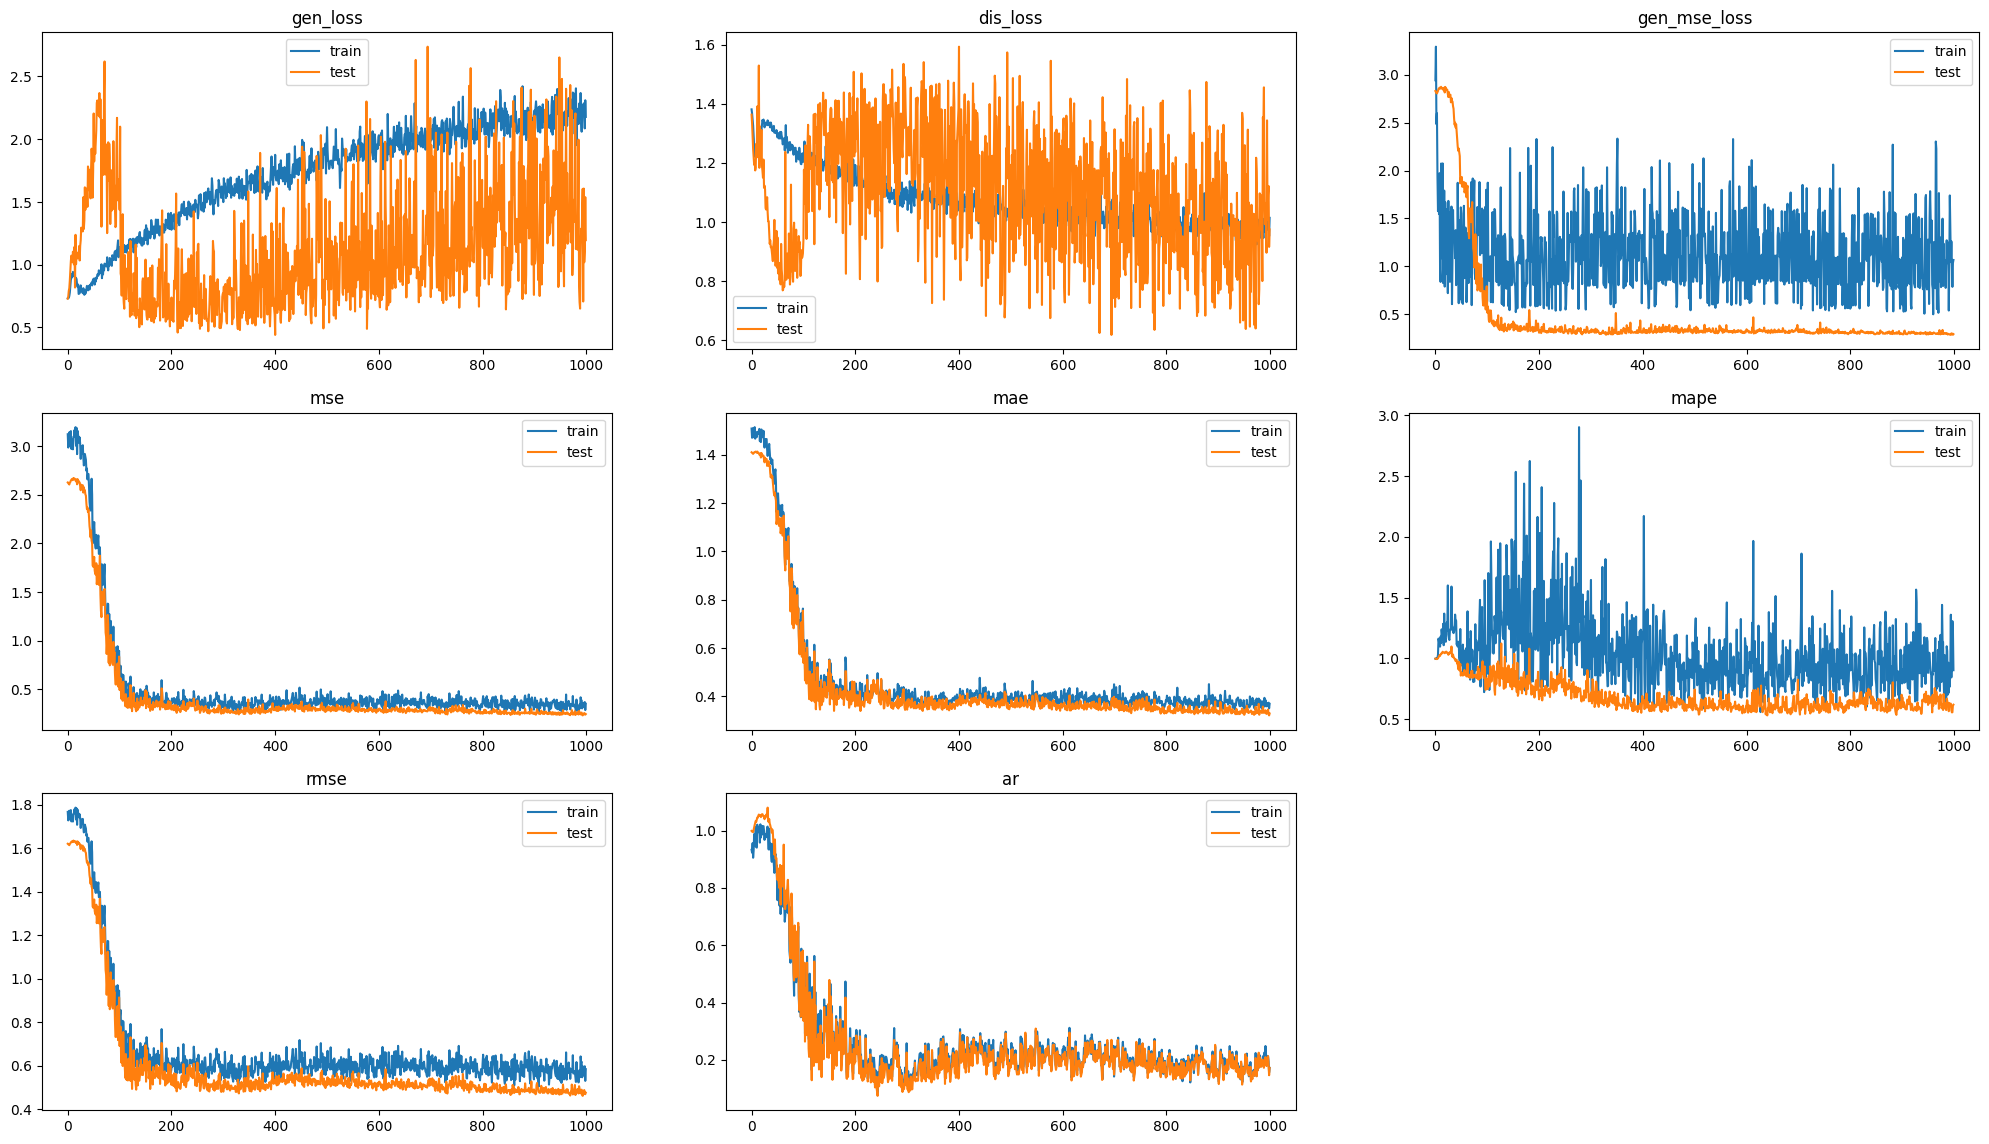

2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - mse: 0.2430 - mae: 0.3294 - mape: 0.6192 - rmse: 0.4751 - ar: 0.1717


,0
loss,1.195753
mse,0.242987
mae,0.329386
mape,0.619214
rmse,0.475116
ar,0.171730


In [ ]:
metrics = ["gen_loss", "dis_loss", "gen_mse_loss", 'mse', 'mae', 'mape', 'rmse', 'ar']
plot_gan_history(history, history_val, metrics)

GAN_evaluation = generator.evaluate(data_gen_test)
GAN_evaluation[0] = history_val[0][-1]
df = pd.DataFrame(data = GAN_evaluation, index = ['loss', 'mse', 'mae', 'mape', 'rmse', 'ar'])
df.head(len(df))

mape:  0.009771906864044071


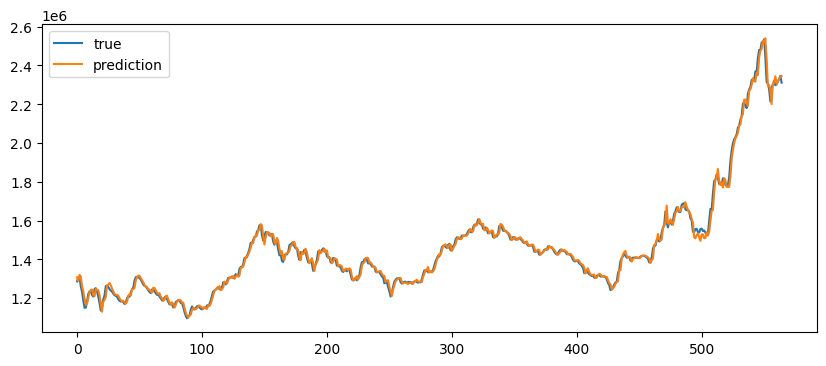

In [ ]:
y_pred_GAN, metrics_GAN = model_result(generator)


# SVR

In [ ]:
# ======================================================================================================================
#                                       Train SVR Model And Train
# ======================================================================================================================

def SVR_model():
    return SVR(kernel='rbf', C=1e6, gamma=1e-5)

scaler = StandardScaler()

data = dataset[..., 3].reshape(-1, 1)
data = scaler.fit_transform(data)

data_gen_train_svr, data_gen_test_svr = get_data_gen_raw(data)

x_train, y_train = collect_all(data_gen_train_svr)
x_test, y_test = collect_all(data_gen_test_svr)

x_train = x_train.reshape((x_train.shape[0], n_sequence))
y_train = y_train.reshape(-1)

x_test = x_test.reshape((x_test.shape[0], n_sequence))
y_test = y_test.reshape(-1)

model_SVR = SVR_model()

model_SVR.fit(x_train, y_train)
pred_SVR = model_SVR.predict(x_test)


mape:  0.013847898656535115


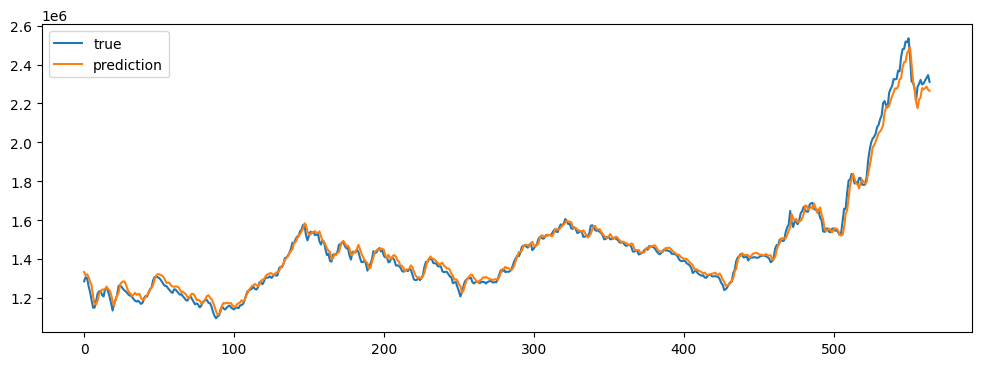

In [ ]:
y_true = y_test
y_pred = pred_SVR

y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
y_pred = scaler.inverse_transform(pred_SVR.reshape(-1, 1)).reshape(-1)
y_pred_SVR = y_pred

metrics_SVR = get_metrics(y_true, y_pred)

# print('mse: ', metrics_SVR['mse'])
# print('mae: ', metrics_SVR['mae'])
print('mape: ', metrics_SVR['mape'])
# print('rmse: ', metrics_SVR['rmse'])
# print('ar: ', metrics_SVR['ar'])

plt.figure(figsize=(12, 4))
plt.plot(y_true, label="true")
plt.plot(y_pred, label="prediction")
plt.legend()
plt.show()


# LSTM

In [ ]:
# ====================================================================================================================
#                                       LSTM Model
# ====================================================================================================================

def LSTM_Model():
    inputs = Input(shape=(n_sequence, n_features))
    lstm_1 = tf.keras.layers.LSTM(10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = tf.keras.layers.BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1)
    lstm_1_droput = Dropout(0.1)(lstm_1_LRelu)
    lstm_2 = tf.keras.layers.LSTM(20, return_sequences=False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
    batch_norm2 = tf.keras.layers.BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2)
    lstm_2_droput = Dropout(0.1)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_droput)
    output = LeakyReLU(alpha=0.3)(output_dense)
    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='mse', optimizer='adam', metrics=[mse, mae, mape, rmse, ar])
    
    return model


In [ ]:
# ======================================================================================================================
#                                       Train LSTM Model
# ======================================================================================================================

model_LSTM = LSTM_Model()
model_LSTM.summary()

history_LSTM = model_LSTM.fit(data_gen_train, validation_data=data_gen_test, epochs=n_epochs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 10)            680       
                                                                 
 batch_normalization_2 (Batc  (None, 20, 10)           40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 10)            0         
                                                                 
 dropout_5 (Dropout)         (None, 20, 10)            0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                2480      
                                                           

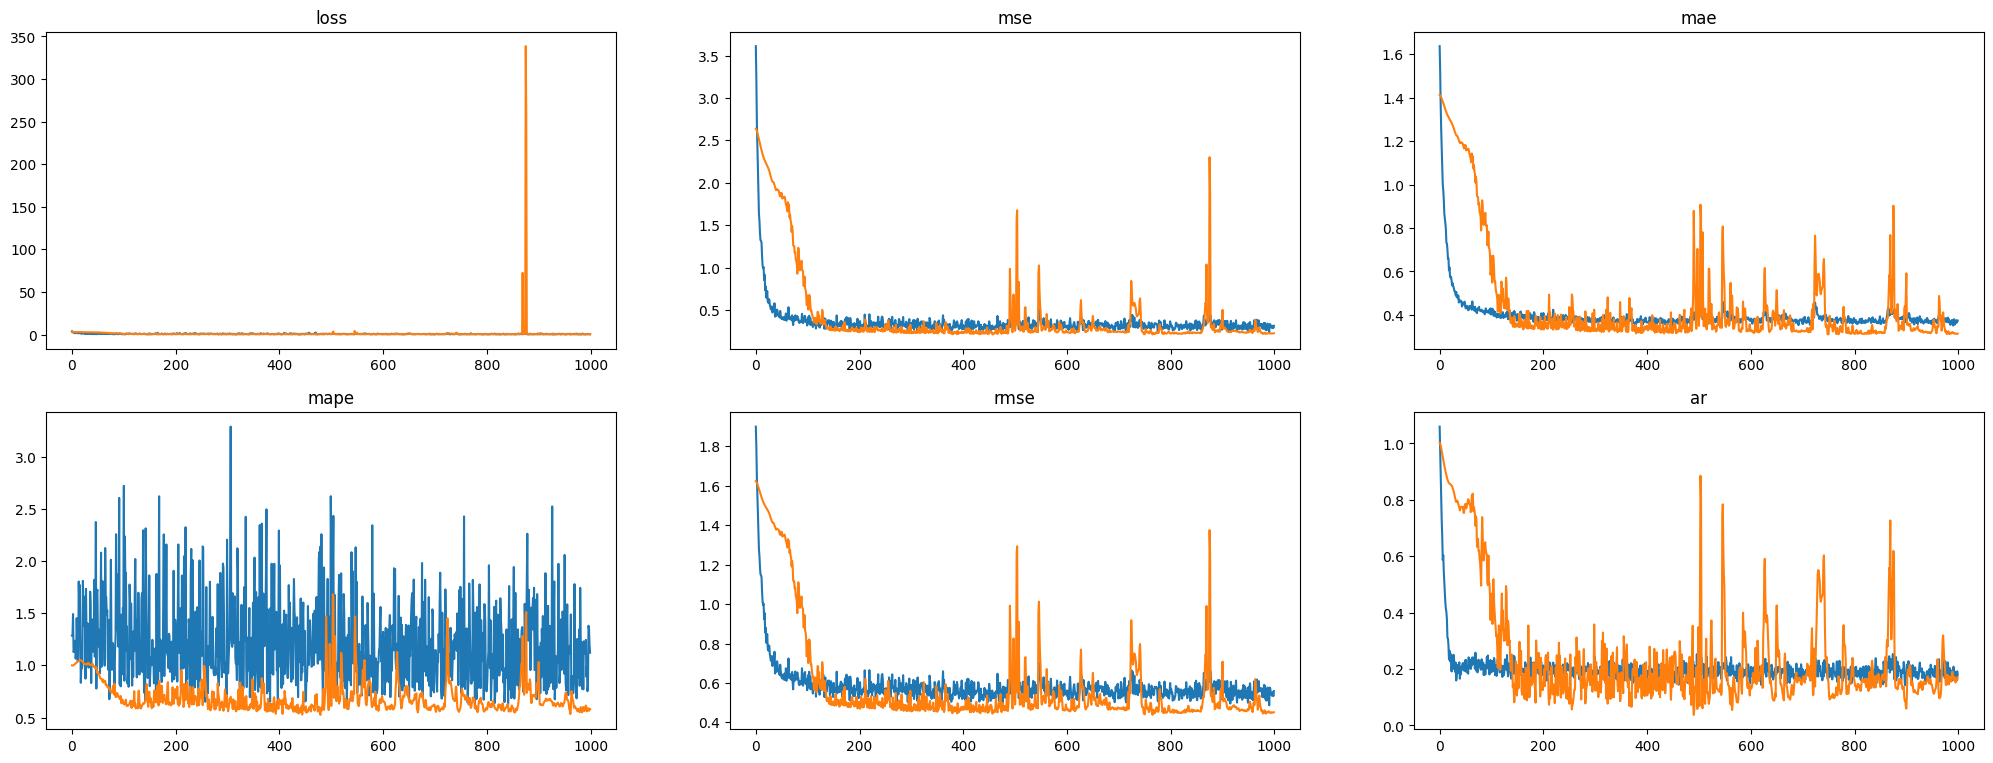

2/2 [==============================] - 0s 14ms/step - loss: 0.4414 - mse: 0.2262 - mae: 0.3143 - mape: 0.5816 - rmse: 0.4516 - ar: 0.1711


,0
loss,0.441368
mse,0.226187
mae,0.314282
mape,0.581577
rmse,0.451590
ar,0.171083


In [ ]:
metrics = ['loss', 'mse', 'mae', 'mape', 'rmse', 'ar']
plot_history(history_LSTM.history, metrics)

LSTM_evaluation = model_LSTM.evaluate(data_gen_test)
df = pd.DataFrame(data = LSTM_evaluation, index = metrics)
df.head(len(df))

mape:  0.009656880592661473


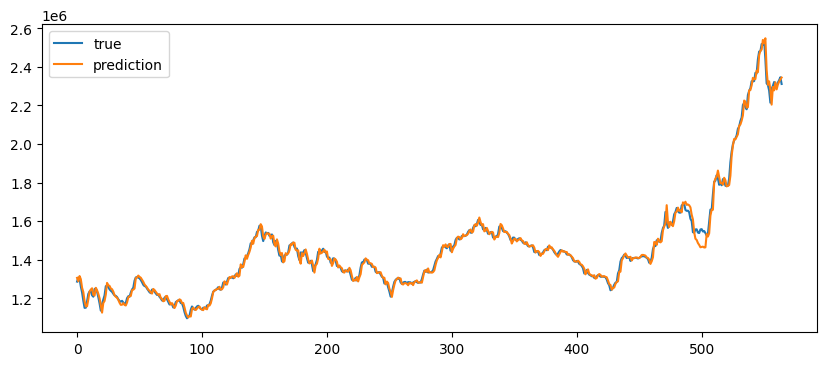

In [ ]:
y_pred_LSTM, metrics_LSTM = model_result(model_LSTM)


# ANN

In [ ]:
# ======================================================================================================================
#                                       ANN Model
# ======================================================================================================================

def ANN_Model():
    model = Sequential()
    model.add(Input(shape=(n_sequence, n_features)))
    model.add(Flatten())
    model.add(Dense(units=72, activation='relu', kernel_initializer='random_normal'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    # model.add(Dropout(0.4))
    model.add(Dense(units=100, activation='relu', kernel_initializer='random_normal'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # model.add(Dropout(0.4))
    model.add(Dense(units=10, activation='relu', kernel_initializer='random_normal'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # model.add(Dropout(0.2))
    model.add(Dense(units=n_features, activation=None))
    model.add(LeakyReLU(alpha=0.3))

    model.compile(loss='mse', optimizer='adam', metrics=[mse, mae, mape, rmse, ar])

    return model


In [ ]:
# ======================================================================================================================
#                                       Train ANN Model
# ======================================================================================================================

model_ANN = ANN_Model()
model_ANN.summary()

history_ANN = model_ANN.fit(data_gen_train, validation_data=data_gen_test, epochs=n_epochs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 120)               0         
                                                                 
 dense_6 (Dense)             (None, 72)                8712      
                                                                 
 dense_7 (Dense)             (None, 100)               7300      
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
 dense_9 (Dense)             (None, 6)                 66        
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6)                 0         
                                                                 
Total params: 17,088
Trainable params: 17,088
Non-trai

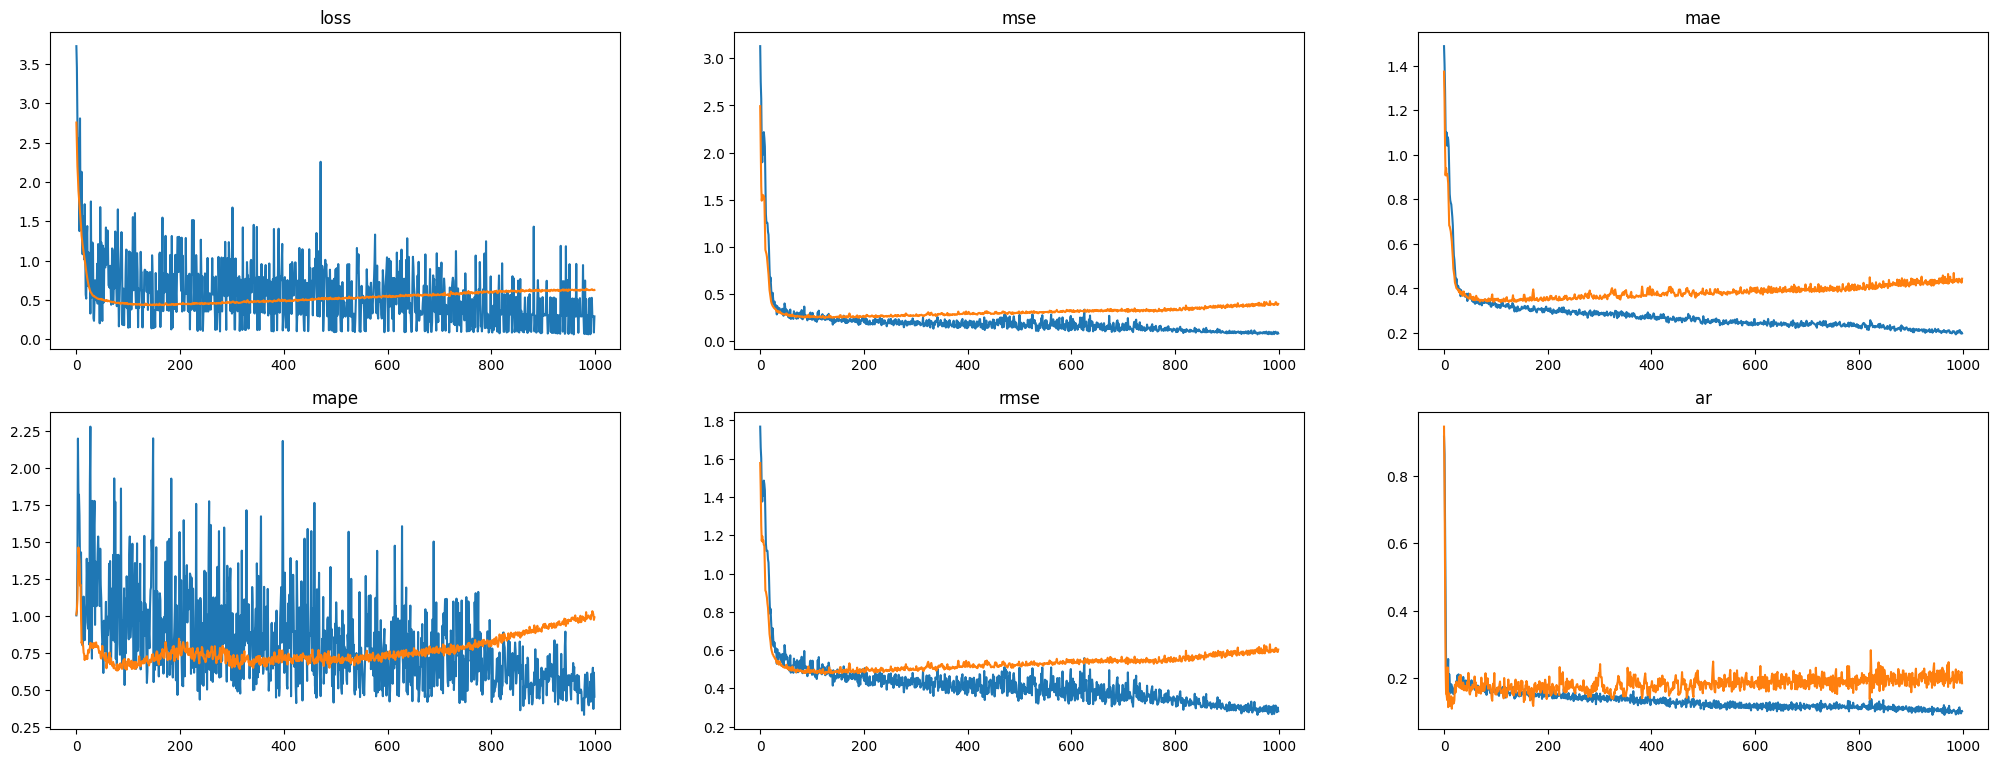

2/2 [==============================] - 0s 16ms/step - loss: 0.6266 - mse: 0.3917 - mae: 0.4437 - mape: 0.9904 - rmse: 0.6029 - ar: 0.1844


,0
loss,0.626608
mse,0.391686
mae,0.443677
mape,0.990351
rmse,0.602897
ar,0.184414


In [ ]:
metrics = ['loss', 'mse', 'mae', 'mape', 'rmse', 'ar']
plot_history(history_ANN.history, metrics)

ANN_evaluation = model_ANN.evaluate(data_gen_test)
df = pd.DataFrame(data = ANN_evaluation, index = metrics)
df.head(len(df))

mape:  0.013105596518398816


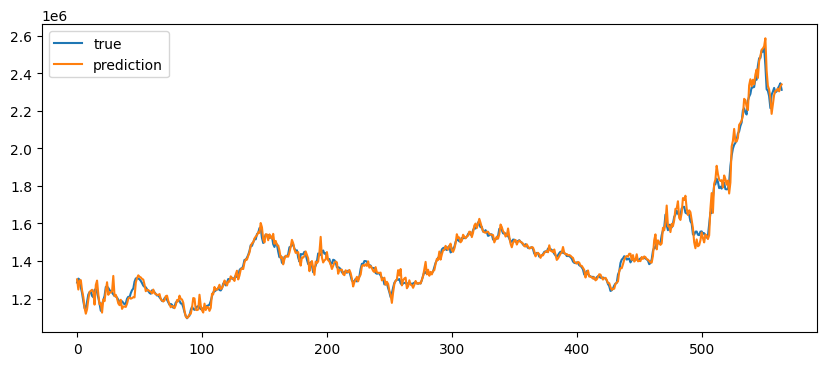

In [ ]:
y_pred_ANN, metrics_ANN = model_result(model_ANN)


# Comparison

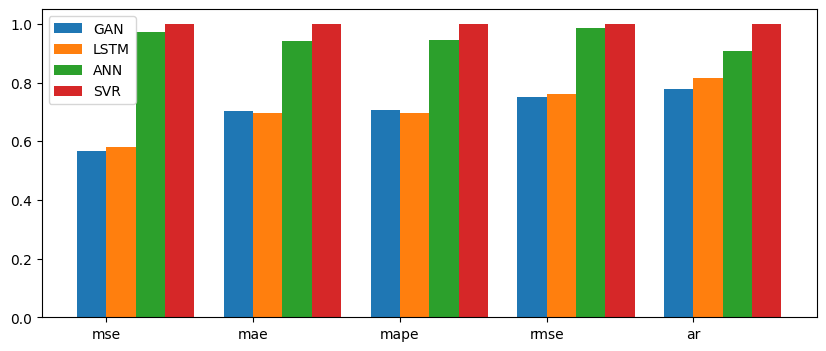

,GAN,LSTM,ANN,SVR
mse,0.566067,0.580129,0.972781,1.0
mae,0.702265,0.696037,0.941910,1.0
mape,0.705660,0.697354,0.946396,1.0
rmse,0.752374,0.761662,0.986297,1.0
ar,0.777637,0.816090,0.906350,1.0


In [ ]:
# Comparing metrics

z = zip(metrics_GAN.values(), metrics_LSTM.values(), metrics_ANN.values(), metrics_SVR.values())
z = np.array(list(z), dtype='float32')
models_metrics = z

z = z.T
w = z / np.max(z, axis=0)

index = ['mse', 'mae', 'mape', 'rmse', 'ar']
columns = ['GAN', 'LSTM', 'ANN', 'SVR']

fig, ax = plt.subplots(figsize=(10, 4))
x = np.arange(len(index))
bar_width = 0.2
for i in range(len(w)):
    ax.bar(x + i * bar_width, w[i], width=bar_width, label=columns[i])
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()
plt.show()

df = pd.DataFrame(data = w.T, index = index, columns = columns)
df.head(len(df))


In [ ]:
df = pd.DataFrame(data = models_metrics, index = index, columns = columns)
df.head(len(df))

,GAN,LSTM,ANN,SVR
mse,4.473291e+08,4.584414e+08,7.687309e+08,7.902406e+08
mae,1.448013e+04,1.435172e+04,1.942142e+04,2.061919e+04
mape,9.771907e-03,9.656881e-03,1.310560e-02,1.384790e-02
rmse,2.115016e+04,2.141124e+04,2.772600e+04,2.811122e+04
ar,1.561651e+02,1.638871e+02,1.820132e+02,2.008199e+02


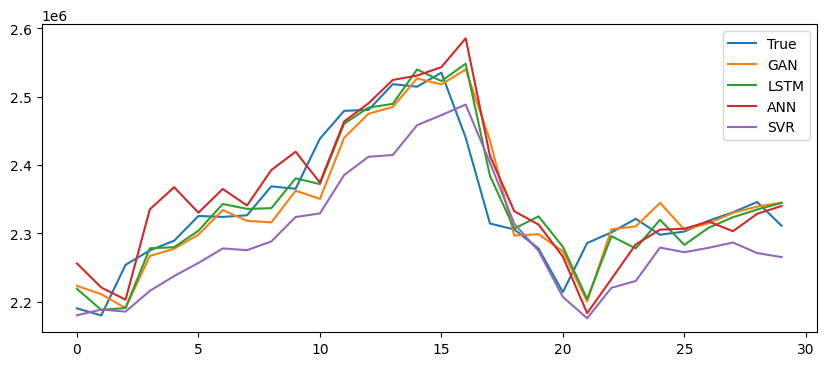

In [ ]:
# Comparing predictions

L = 30

columns = ['True', 'GAN', 'LSTM', 'ANN', 'SVR']

z = zip(Y_test_raw[..., 3], y_pred_GAN, y_pred_LSTM, y_pred_ANN, y_pred_SVR)
z = np.array(list(z), dtype='int')
models_predictions = z

w = z[-L:].reshape(L, len(columns))
w = w.T

plt.figure(figsize=(10, 4))
for i in range(len(columns)):
    plt.plot(w[i], label=columns[i])
plt.legend()
plt.show()


In [ ]:
df = pd.DataFrame(data = models_predictions[-L:], columns = columns)
df.head(len(df))

,True,GAN,LSTM,ANN,SVR
0,2190307,2223217,2218868,2256011,2180160
1,2179922,2210937,2187974,2220832,2188570
2,2253946,2190685,2190895,2202982,2185544
3,2275067,2267020,2278137,2335251,2215879
4,2289287,2277529,2279798,2367595,2237592
5,2325437,2298229,2303851,2330300,2256781
6,2324133,2334167,2343018,2365039,2277988
7,2326494,2318332,2335881,2340802,2275462
8,2368829,2316140,2336850,2392716,2288170
9,2365287,2362455,2380523,2419514,2323962
